In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import geostatspy.GSLIB as gslib
import geostatspy.geostats as geostats
from scipy import stats
%matplotlib inline

# Import Excel project files

In [2]:
df = pd.read_csv("UG90 PROJECT.csv") #Create a data frame containing UG90 data called df
# Increasing the X and Y coordinates by 0.001
df_mod = df.copy()
df_mod['X'] = df['X'] + 0.001
df_mod['Y'] = df['Y'] + 0.001

In [3]:
df_lease = pd.read_excel('lease Boundary.xlsx')
df_measured = pd.read_excel('UG2 measured.xlsx')

# Import ML libraries

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Train-Test split

In [5]:
all_features = ['X','Y','PT','PD']
target = 'PGE'

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_mod[all_features], df_mod[target], test_size=0.2, random_state=99)

# Initialise Models

In [7]:
models = {
    'Linear Regression': LinearRegression(),
    'SVM': SVR(kernel = 'rbf', gamma = 'scale', epsilon = 0.8, C = 150),
    'SVM2': make_pipeline(StandardScaler(), SVR(kernel = 'rbf', gamma = 'scale', epsilon = 0.8, C = 150)),
    'Decision Tree': DecisionTreeRegressor(min_samples_split = 10, max_depth = 25,criterion= 'friedman_mse'),
    'Random Forest': RandomForestRegressor(n_estimators = 200, min_samples_split = 3, max_depth = 20, criterion= 'friedman_mse'),
    'KNN': make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=3, weights='distance', metric='euclidean'))
}

# KNN

In [8]:
## Point Prediction

In [8]:
knnr = models['KNN']

In [9]:
knnr.fit(X_train[['X','Y']], y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor',
                 KNeighborsRegressor(metric='euclidean', n_neighbors=3,
                                     weights='distance'))])

In [10]:
knnr_point = knnr.predict(df_mod[['X','Y']])

In [11]:
ressi = knnr_point - df_mod['PGE'].values

In [12]:
np.mean(knnr_point)

5.75794647355515

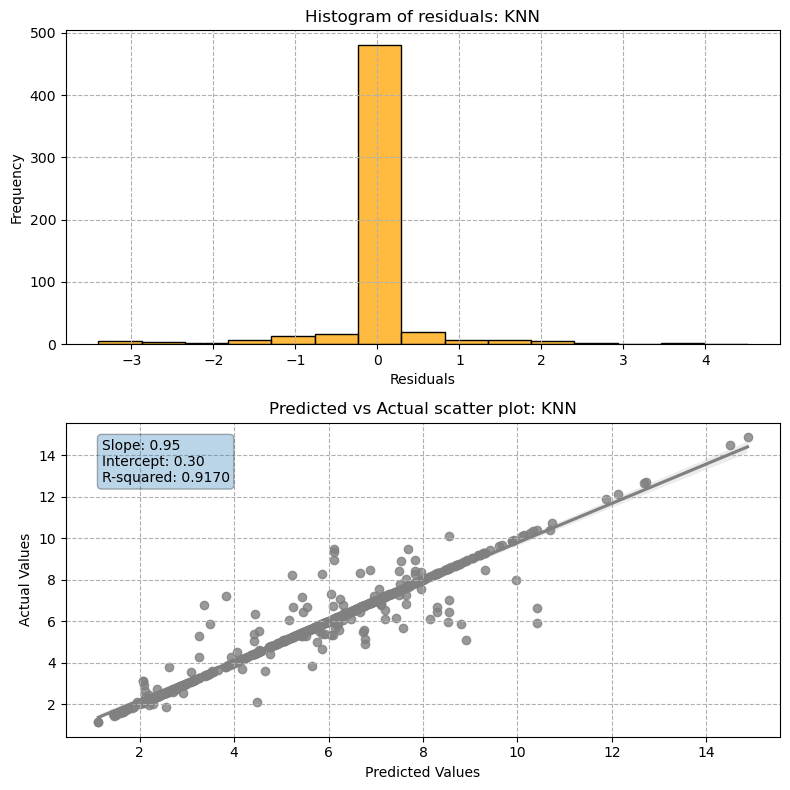

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 3]})

# First subplot for histogram of residuals
sns.histplot(ressi, kde=False, bins=15, color='orange', ax=axs[0])
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of residuals: KNN')
axs[0].grid(ls='--')

# Second subplot for scatter plot of predicted vs actual values with regression line
sns.regplot(x=knnr_point, y=df_mod['PGE'], color='gray', ax=axs[1])

# Calculate the linear regression values
slope, intercept, r_value, p_value, std_err = stats.linregress(knnr_point, df_mod['PGE'])

# Annotate the slope, intercept, and R-squared on the plot
text = f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nR-squared: {r_value**2:.4f}'
axs[1].annotate(text, xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', 
                bbox=dict(boxstyle='round', alpha=0.3))

# Set labels and title
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Actual Values')
axs[1].set_title('Predicted vs Actual scatter plot: KNN')
axs[1].grid(ls='--')

# Adjust the layout so titles and labels don't overlap
plt.tight_layout()

# Show the plots
plt.show()

In [14]:
def calculate_regression_metrics(y_true, y_pred):
    """
    Calculate R-squared, RMSE, and MSE for the given true and predicted values.

    Parameters:
    y_true (array-like): True values.
    y_pred (array-like): Predicted values.

    Returns:
    dict: A dictionary containing R-squared, RMSE, and MSE.
    """
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)

    return {
        
        'RMSE': rmse,
        'MSE': mse,
        'MAE': mae
    }

In [15]:
calculate_regression_metrics(knnr_point, df_mod['PGE'].values)

{'RMSE': 0.6440069445153396,
 'MSE': 0.4147449445839837,
 'MAE': 0.2106261528493713}

# Block Prediction

## Set up ML prediction grid

In [16]:
# Grid dimensions
total_blocks_x, total_blocks_y = 250, 250  # Total number of blocks in x and y directions
block_size = 33  # Size of each block (assuming square blocks)
discretization_per_block = 2  # Discretization points per block dimension

# Calculate total grid size
grid_size_x = total_blocks_x * block_size
grid_size_y = total_blocks_y * block_size

# Calculate discretization point spacing within a block
dis_spacing = block_size / discretization_per_block

# Generate discretization points
# Note: Adjust xmin, xmax, ymin, ymax based on the actual area you want to cover
xmin, xmax = df_measured['X'].min(), df_measured['X'].max()
ymin, ymax = df_measured['Y'].min(), df_measured['Y'].max()


# Adjusting to cover the full extent of the grid if df_measured is limited
# Here, you might need to manually set xmin, xmax, ymin, ymax to cover the desired area fully

dis_points_x, dis_points_y = [], []

for x_block in range(total_blocks_x):
    for y_block in range(total_blocks_y):
        for dx in range(discretization_per_block):
            for dy in range(discretization_per_block):
                # Calculate the coordinates of each discretization point
                x_coord = xmin + x_block * block_size + dx * dis_spacing + dis_spacing / 2
                y_coord = ymin + y_block * block_size + dy * dis_spacing + dis_spacing / 2
                dis_points_x.append(x_coord)
                dis_points_y.append(y_coord)

# DataFrame for ML predictions
df_dis_points = pd.DataFrame({'X': dis_points_x, 'Y': dis_points_y})


In [17]:
dis_point_predictionknnr = knnr.predict(df_dis_points)

In [18]:
df_mod_copy = df_mod.copy()

In [19]:
# Assuming dis_point_predictions are in the same order as the discretization points were generated
# And assuming df_dis_points has the same order and length as dis_point_predictions

# Add predictions to the DataFrame
df_dis_points['PredictionsKNNR'] = dis_point_predictionknnr

df_dis_points['block_x_index'] = ((df_dis_points['X'] - xmin) // block_size).astype(int)
df_dis_points['block_y_index'] = ((df_dis_points['Y'] - ymin) // block_size).astype(int)

# Aggregate predictions by block
block_predictions = df_dis_points.groupby(['block_x_index', 'block_y_index'])['PredictionsKNNR'].mean().reset_index()
block_predictions.rename(columns={'PredictionsKNNR': 'BlockPredictionsKNNR'}, inplace=True)

df_mod_copy['block_x_index'] = ((df_mod_copy['X'] - xmin) // block_size).astype(int)
df_mod_copy['block_y_index'] = ((df_mod_copy['Y'] - ymin) // block_size).astype(int)

# Merge aggregated block predictions with original data points based on block indices
df_mod_copy = pd.merge(df_mod_copy, block_predictions, on=['block_x_index', 'block_y_index'], how='left')

In [20]:
blk = block_predictions['BlockPredictionsKNNR']

blk_array = np.array(blk)  # Convert to numpy array if blk is a Pandas Series

# Reshape the array to (250, 250)
blk_reshaped = blk_array.reshape((250, 250))

# blk_reshaped is now a 2D numpy array with shape (250, 250)

In [21]:
np.mean(blk_array), blk_array.min(),blk_array.max(), blk_reshaped.shape

(6.251287832308691, 1.4166199552879526, 13.847475121174265, (250, 250))

In [22]:
residknnr = df_mod_copy['BlockPredictionsKNNR'].values - df_mod_copy['PGE'].values

# Visualisation and Metrics

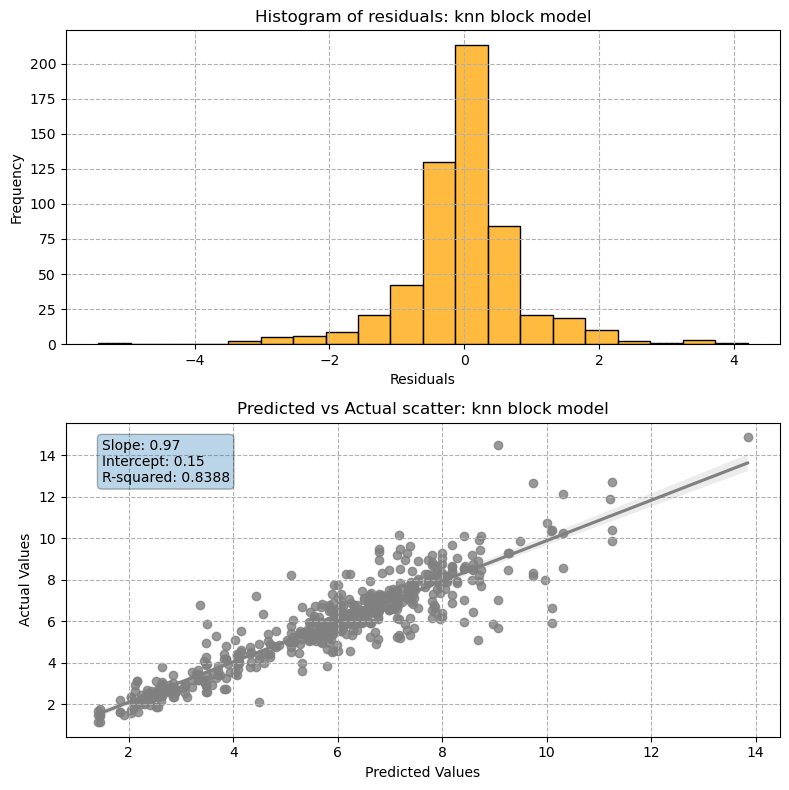

In [23]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 3]})

# First subplot for histogram of residuals
sns.histplot(residknnr, kde=False, bins=20, color='orange', ax=axs[0])
axs[0].set_xlabel('Residuals')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of residuals: knn block model')
axs[0].grid(ls='--')

# Second subplot for scatter plot of predicted vs actual values with regression line
sns.regplot(x=df_mod_copy['BlockPredictionsKNNR'], y=df_mod_copy['PGE'], color='gray', ax=axs[1])

# Calculate the linear regression values
slope, intercept, r_value, p_value, std_err = stats.linregress(df_mod_copy['BlockPredictionsKNNR'], df_mod_copy['PGE'])

# Annotate the slope, intercept, and R-squared on the plot
text = f'Slope: {slope:.2f}\nIntercept: {intercept:.2f}\nR-squared: {r_value**2:.4f}'
axs[1].annotate(text, xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top', 
                bbox=dict(boxstyle='round', alpha=0.3))

# Set labels and title
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Actual Values')
axs[1].set_title('Predicted vs Actual scatter: knn block model')
axs[1].grid(ls='--')

# Adjust the layout so titles and labels don't overlap
plt.tight_layout()

# Show the plots
plt.show()

In [24]:
calculate_regression_metrics( df_mod_copy['BlockPredictionsKNNR'], df_mod_copy['PGE'])

{'RMSE': 0.8844887020398534,
 'MSE': 0.7823202640361445,
 'MAE': 0.5739704319778591}

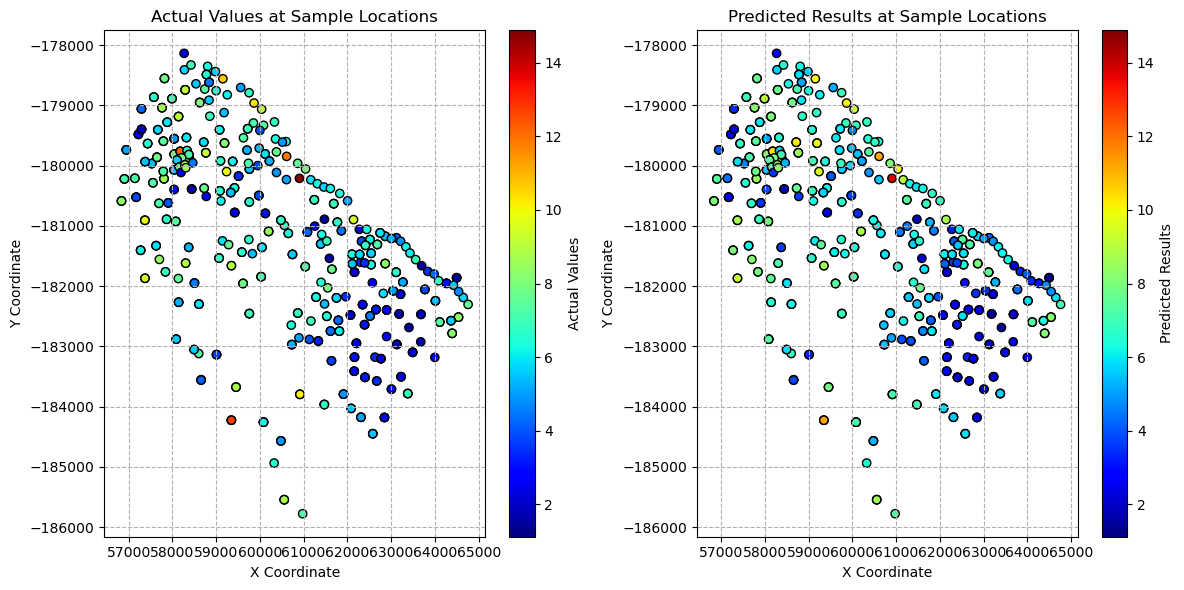

In [25]:
# Find the global minimum and maximum values for the color scale
vmin = min(df_mod['PGE'].min(), df_mod_copy['BlockPredictionsKNNR'].min())
vmax = max(df_mod['PGE'].max(), df_mod_copy['BlockPredictionsKNNR'].max())

# Scatter plot of actual values at locations in df_mod
plt.figure(figsize=(12, 6))

# First subplot for actual values
plt.subplot(1, 2, 1)
scatter = plt.scatter(df_mod['X'], df_mod['Y'], c=df_mod['PGE'], cmap='jet', edgecolor='black', vmin=vmin, vmax=vmax)
plt.colorbar(scatter, label='Actual Values')
plt.title('Actual Values at Sample Locations')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(ls="--")

# Second subplot for predicted values
plt.subplot(1, 2, 2)
scatter = plt.scatter(df_mod_copy['X'], df_mod_copy['Y'], c=df_mod_copy['BlockPredictionsKNNR'], cmap='jet', edgecolor='black', vmin=vmin, vmax=vmax)
plt.colorbar(scatter, label='Predicted Results')
plt.title('Predicted Results at Sample Locations')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(ls="--")

plt.tight_layout()
plt.show()

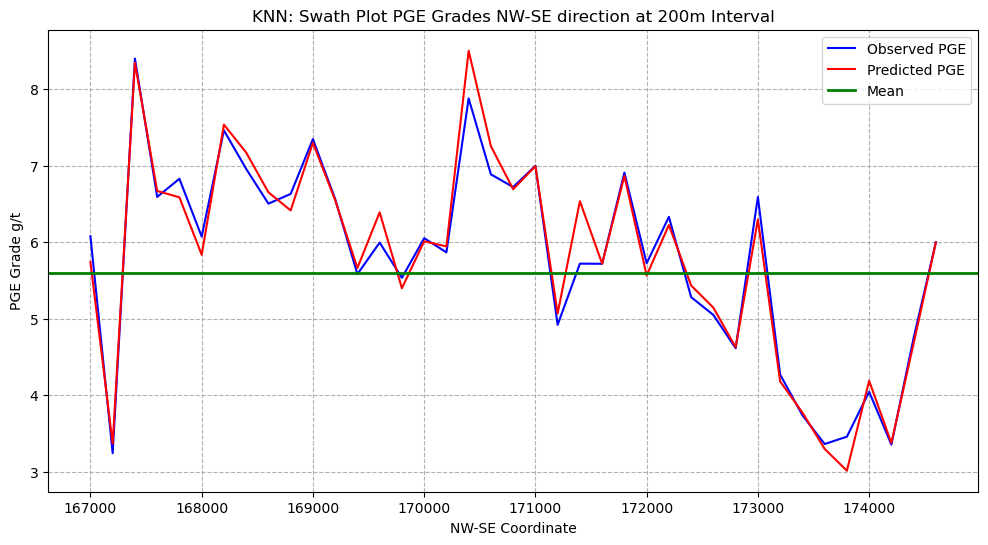

In [26]:
# Convert the angle to radians for computation
rotation_angle = np.radians(-45)

# Calculate the rotated coordinates for NW-SE direction
df_mod_copy['NW_SE_Coord'] = df_mod_copy['X'] * np.cos(rotation_angle) + df_mod_copy['Y'] * np.sin(rotation_angle)

# Define the interval for the rotated coordinate grouping
nw_se_interval = 200

# Calculate the NW-SE groups by using the new NW_SE_Coord
df_mod_copy['NW_SE_Group'] = (df_mod_copy['NW_SE_Coord'] // nw_se_interval) * nw_se_interval

# Calculate the mean PGE for each NW-SE group
grouped_df = df_mod_copy.groupby('NW_SE_Group').mean().reset_index()

# Create the swath plot with averaged values for the NW-SE direction
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_df, x='NW_SE_Group', y='PGE', label='Observed PGE', color='blue')
sns.lineplot(data=grouped_df, x='NW_SE_Group', y='BlockPredictionsKNNR', label='Predicted PGE', color='red')

plt.axhline(y=5.6, color='green', linestyle='-', linewidth=2, label='Mean')

# Adjust the labels to reflect the NW-SE direction
plt.title('KNN: Swath Plot PGE Grades NW-SE direction at 200m Interval')
plt.xlabel('NW-SE Coordinate')
plt.ylabel('PGE Grade g/t')
plt.legend()
plt.grid(True, ls='--')
plt.show()

In [29]:
df_mod_copy['NW_SE_Group'].dtype

dtype('float64')

## Estimate Map

In [27]:
import geopandas as gpd
from shapely.geometry import Polygon
from shapely.validation import explain_validity
#from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import scipy

In [28]:
# Assuming df_measured contains the X and Y coordinates for the boundary
if not df_measured.X.empty and not df_measured.Y.empty:
    df_measured['X'] = pd.to_numeric(df_measured.X, errors='coerce')
    df_measured['Y'] = pd.to_numeric(df_measured.Y, errors='coerce')
    
    if df_measured.X.notna().all() and df_measured.Y.notna().all():
        coords = list(zip(df_measured.X, df_measured.Y))
        
        # Ensure the polygon forms a closed loop
        if coords[0] != coords[-1]:
            coords.append(coords[0])
        
        boundary_polygon = Polygon(coords)
        
        # Check if the polygon is valid using Shapely's is_valid
        if not boundary_polygon.is_valid:
            raise ValueError("The created polygon is not valid.")

        boundary_gdf = gpd.GeoDataFrame(geometry=[boundary_polygon], crs="EPSG:32735")
    else:
        raise ValueError("DataFrame columns X and Y contain non-numeric values.")
else:
    raise ValueError("DataFrame columns X and Y are empty.")
# Assuming df_mod contains the points to be kriged
gdf = gpd.GeoDataFrame(df_mod, geometry=gpd.points_from_xy(df_mod.X, df_mod.Y))
# Make sure the CRS for both GeoDataFrames match before the spatial join
gdf.crs = boundary_gdf.crs
# Perform spatial join to filter points within the boundary
gdf_within_boundary = gpd.sjoin(gdf, boundary_gdf, predicate='within')

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 'boundary_gdf' is your GeoDataFrame with the boundary polygon
# 'gdf_within_boundary' contains the points within the boundary

# First, convert the 2D array of knn estimates to a GeoDataFrame
# Create an (x, y) grid of points that corresponds to the kriging estimates
x_coords = np.linspace(xmin, xmax + (250 - 1), 250)
y_coords = np.linspace(ymin, ymax + (250 - 1), 250)
x_grid, y_grid = np.meshgrid(x_coords, y_coords)

# Flatten the grid and estimates for creating a GeoDataFrame
x_grid_flat = x_grid.ravel()
y_grid_flat = y_grid.ravel()
knn_flat = blk_reshaped.ravel()

# Create a GeoDataFrame from the flattened grid and estimates

knn_gdf = gpd.GeoDataFrame(
    {'Estimate': knn_flat},
    geometry=gpd.points_from_xy(x_grid_flat, y_grid_flat),
    crs="EPSG:32735"  # Ensure the CRS matches that of the boundary
)

# Clip the knn estimates to the boundary polygon
clipped_knn_gdf = gpd.clip(knn_gdf, boundary_gdf).copy()

# Extract X and Y coordinates from the 'geometry' column
clipped_knn_gdf['X'] = clipped_knn_gdf.geometry.x
clipped_knn_gdf['Y'] = clipped_knn_gdf.geometry.y

# Pivot the DataFrame to match the original knn estimate grid size
clipped_knnmap = clipped_knn_gdf.pivot(index='Y', columns='X', values='Estimate').fillna(np.nan).values

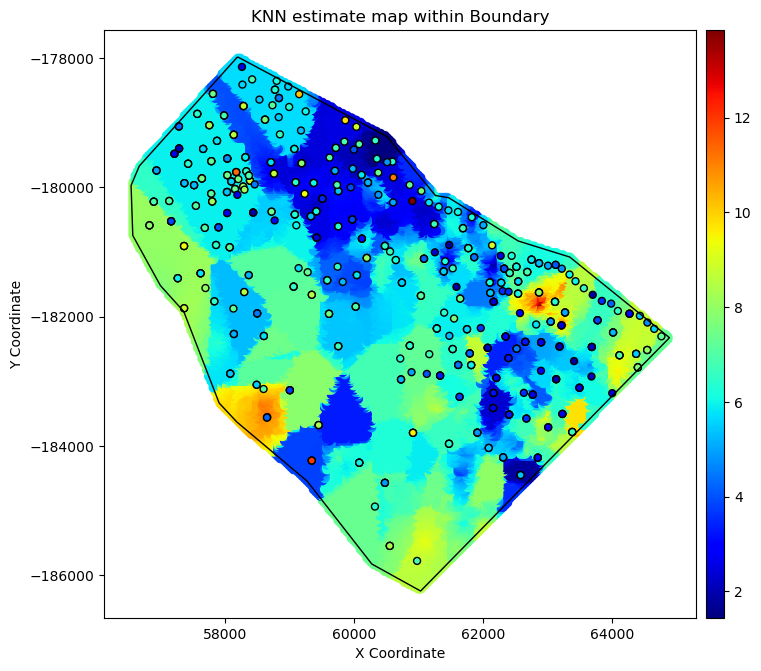

In [30]:
# Now we can visualize the clipped knn estimates
fig, ax = plt.subplots(figsize=(8, 8))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

# Plotting the clipped knn estimates
clipped_knn_gdf.plot(column='Estimate', ax=ax, legend=True, cax=cax, cmap='jet')

# Overlay the boundary for reference
boundary_gdf.boundary.plot(ax=ax, color='black', linewidth=1, ls = '-')

# Overlay the sample points within the boundary
gdf_within_boundary.plot(ax=ax, column='PGE', edgecolor='black', markersize=25, cmap='jet')


# Customize the plot with labels and a title
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('KNN estimate map within Boundary')

# Show the plot
plt.show()